Clustering Households into Rural and Urban Segments using Spending Patterns

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder




In [24]:
path = "../Data/processed/ground_truth_households.csv"
df = pd.read_csv(path, engine="python", encoding="utf-8", on_bad_lines="skip")
df

,common_id,sector,household_size,avg_age,total_expenditure,avg_transaction_value,total_transactions,unique_items_purchased
0,HCES2022655561010131113011101202nan201,13,5,31.400000,10148.0,241.619048,42.0,42.0
1,HCES2022655561010131113011101202nan301,13,6,34.833333,8784.0,204.279070,43.0,43.0
2,HCES2022655561010131113011101202nan302,13,8,26.625000,10916.0,248.090909,44.0,44.0
3,HCES2022655561010131113011101202nan303,13,4,19.000000,7352.0,163.377778,45.0,45.0
4,HCES2022655561010131113011101202nan304,13,4,31.750000,6896.0,156.727273,44.0,44.0
...,...,...,...,...,...,...,...,...
261741,HCES20223951022828313220210228101nan314,22,2,52.000000,4153.0,83.060000,50.0,50.0
261742,HCES20223951022828313220210228101nan315,22,4,32.250000,7688.0,147.846154,52.0,52.0
261743,HCES20223951022828313220210228101nan316,22,3,39.333333,5336.0,106.720000,50.0,50.0
261744,HCES20223951022828313220210228101nan317,22,5,35.800000,7506.0,123.049180,61.0,61.0


In [25]:
cols = ["total_expenditure","avg_transaction_value","total_transactions","unique_items_purchased","household_size","avg_age"]
for c in cols:
    if c not in df.columns:
        df[c] = np.nan
df = df[cols].copy()
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

In [26]:
for c in ["total_expenditure","avg_transaction_value","total_transactions"]:
    df.loc[df[c] < 0, c] = np.nan
#negetive values to NaN

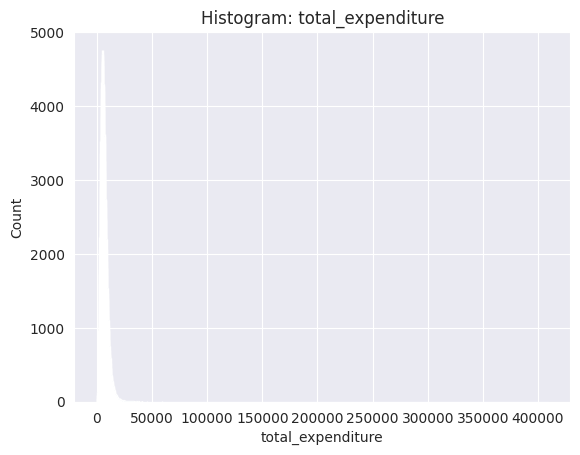

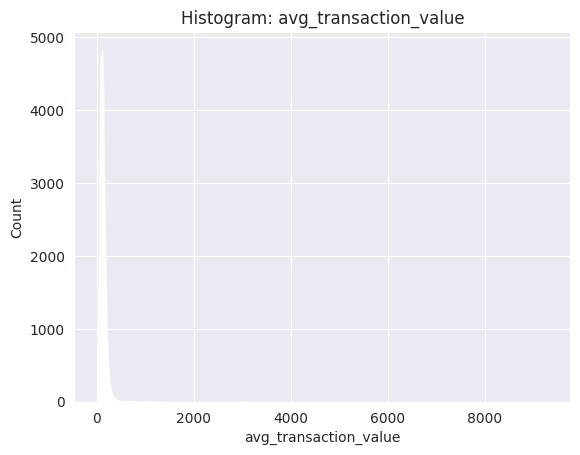

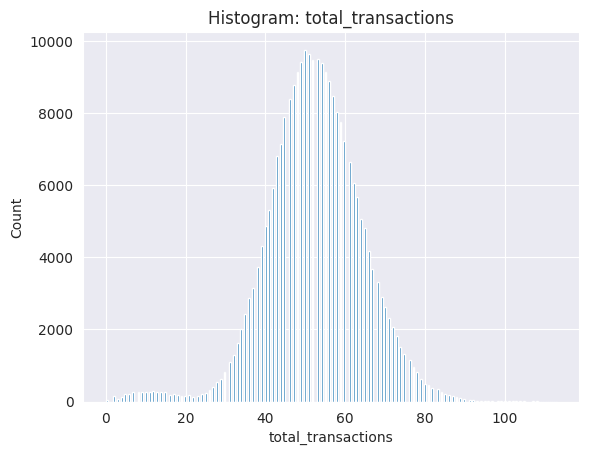

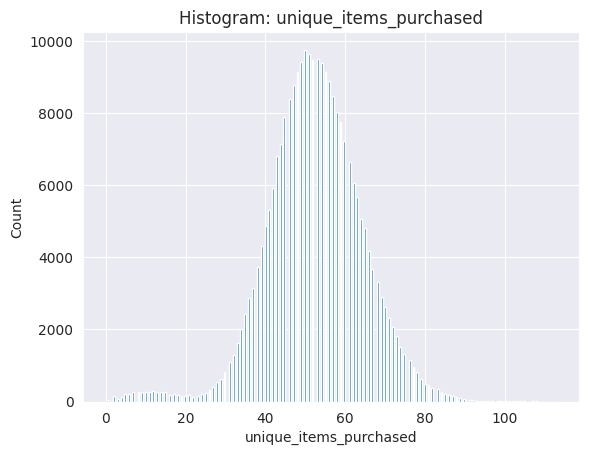

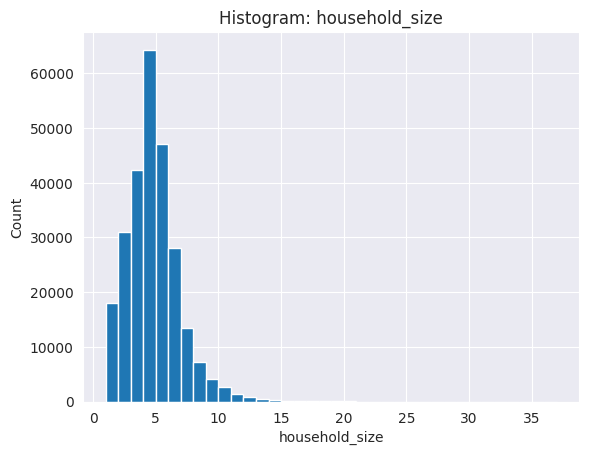

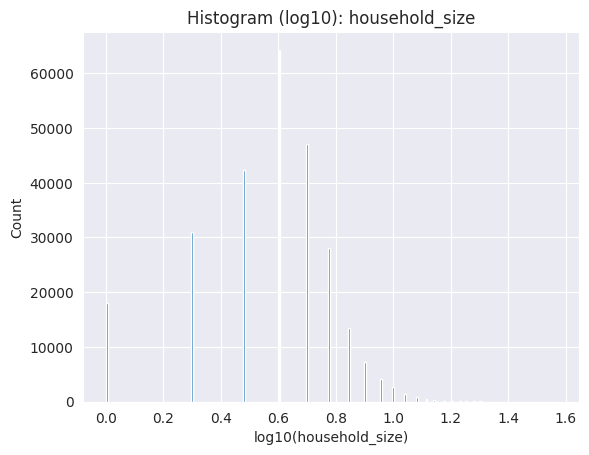

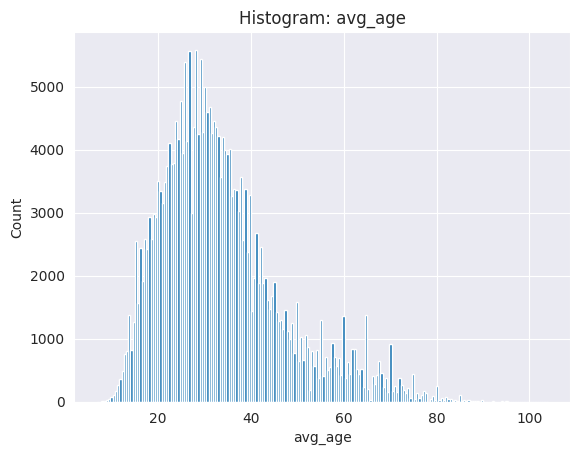

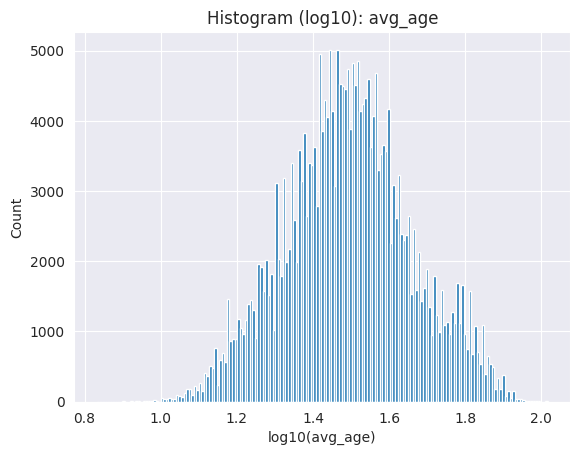

In [48]:
for c in cols:
    s = df[c].dropna()
    if s.empty: continue

    # Linear
    plt.figure(); plt.hist(s, bins="fd");plt.title(f"Histogram: {c}"); plt.xlabel(c); plt.ylabel("Count"); plt.show()

    # Log-x (only if all positive)
    if (s > 0).all():
        plt.figure(); plt.hist(np.log10(s), bins="fd"); plt.title(f"Histogram (log10): {c}"); plt.xlabel(f"log10({c})"); plt.ylabel("Count"); plt.show()


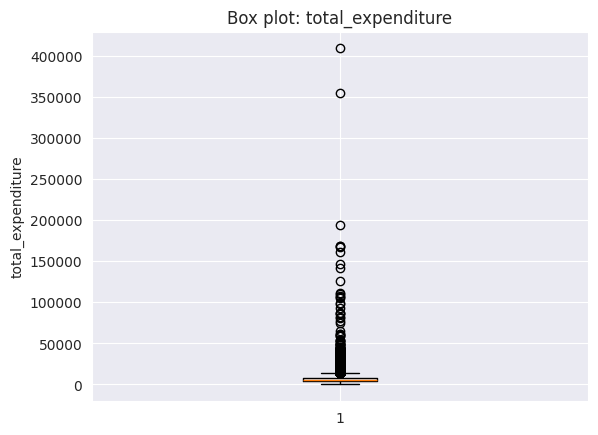

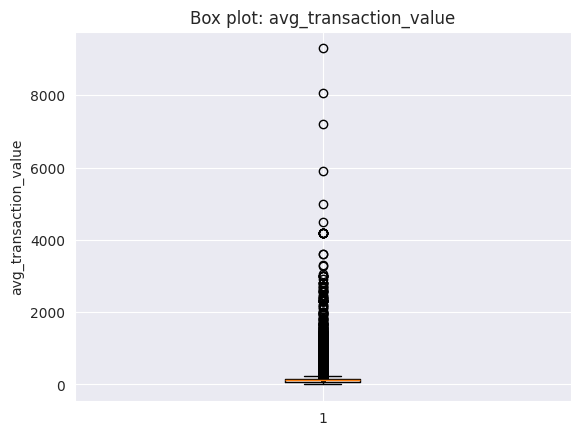

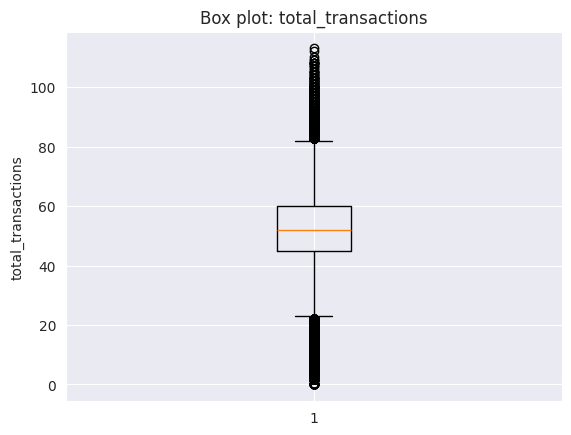

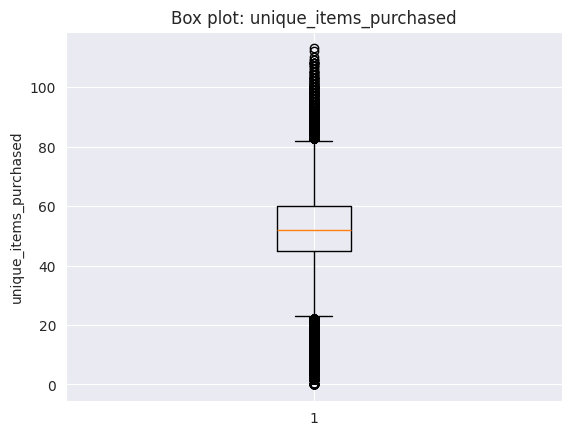

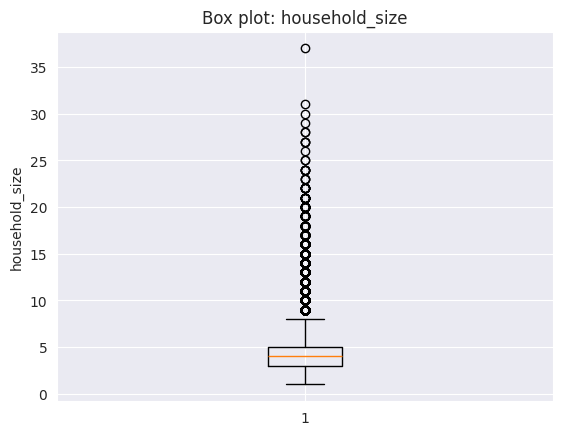

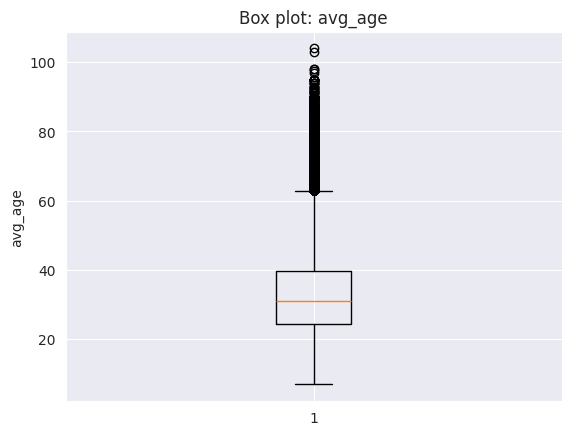

In [28]:
for c in cols:
    s = df[c].dropna()
    if s.empty: continue
    plt.figure(); plt.boxplot(s, vert=True, showfliers=True)
    plt.title(f"Box plot: {c}"); plt.ylabel(c); plt.show()

In [29]:
path = "../Data/processed/ground_truth_households.csv"
df = pd.read_csv(path, engine="python", encoding="utf-8", on_bad_lines="skip")

# 2. Select the features to cluster on
features = [
    'total_expenditure',
    'avg_transaction_value',
    'total_transactions',
    'unique_items_purchased'
]
X = df[features]

# 3. Run KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

# 4. Determine which cluster is "Urban" and which is "Rural"
cluster_means = df.groupby('cluster')['total_expenditure'].mean()
urban_cluster = cluster_means.idxmax()   # higher spend = likely urban
rural_cluster = cluster_means.idxmin()

# 5. Map clusters to labels
df['predicted_area_type'] = df['cluster'].map({
    urban_cluster: 'Urban',
    rural_cluster: 'Rural'
})

# 6. View results
print(cluster_means)
print(df['predicted_area_type'].value_counts())

# 7. Save to CSV if needed
df.to_csv("classified_households.csv", index=False)


cluster
0     4775.581940
1    10606.626774
Name: total_expenditure, dtype: float64
predicted_area_type
Rural    192970
Urban     68776
Name: count, dtype: int64


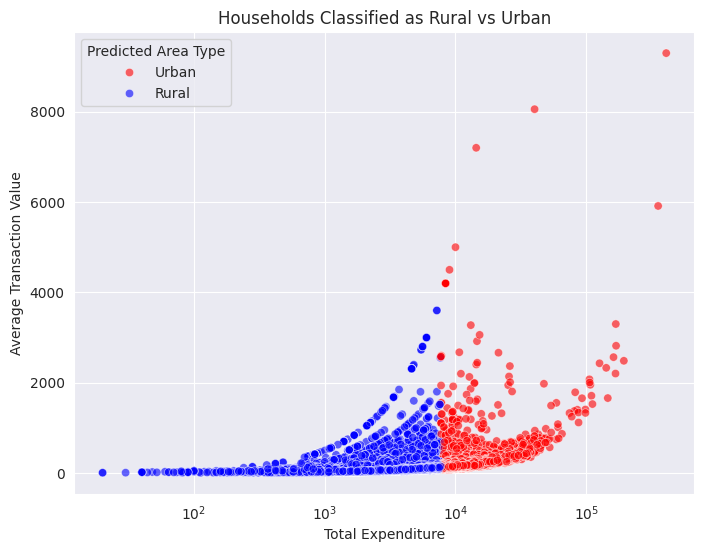

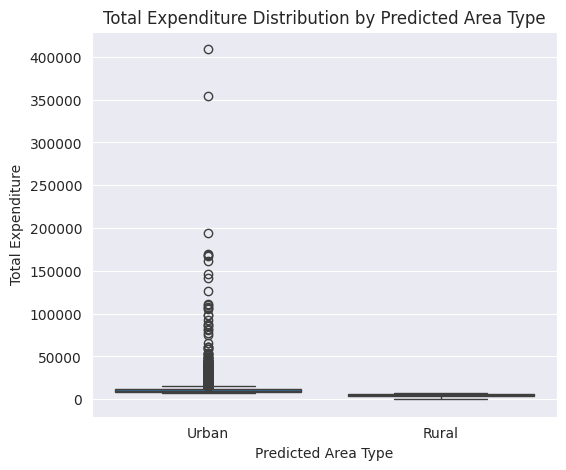

In [30]:
# 1. Scatter plot: total_expenditure vs avg_transaction_value
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='total_expenditure',
    y='avg_transaction_value',
    hue='predicted_area_type',
    palette={'Urban': 'red', 'Rural': 'blue'},
    alpha=0.6
)
plt.xscale('log')
plt.title("Households Classified as Rural vs Urban")
plt.xlabel("Total Expenditure")
plt.ylabel("Average Transaction Value")
plt.legend(title="Predicted Area Type")
plt.show()

# 2. Box plot: distribution of total_expenditure
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=df,
    x='predicted_area_type',
    y='total_expenditure',
    #palette={'Urban': 'red', 'Rural': 'blue'}
)
plt.title("Total Expenditure Distribution by Predicted Area Type")
plt.xlabel("Predicted Area Type")
plt.ylabel("Total Expenditure")
plt.show()


In [31]:
print(df.groupby('predicted_area_type')[features].mean())

                     total_expenditure  avg_transaction_value  \
predicted_area_type                                             
Rural                      4775.581940              99.933297   
Urban                     10606.626774             184.463950   

                     total_transactions  unique_items_purchased  
predicted_area_type                                              
Rural                         49.683459               49.683459  
Urban                         59.715569               59.715569  


In [32]:
for seed in [0, 10, 42, 99]:
    kmeans = KMeans(n_clusters=2, random_state=seed, n_init=10)
    labels = kmeans.fit_predict(X)
    print(seed, pd.Series(labels).value_counts())


0 0    192970
1     68776
Name: count, dtype: int64
10 0    192970
1     68776
Name: count, dtype: int64
42 0    192970
1     68776
Name: count, dtype: int64
99 0    192970
1     68776
Name: count, dtype: int64


In [33]:
print(df.groupby('cluster')[['total_expenditure', 'avg_transaction_value', 'total_transactions', 'unique_items_purchased']].mean())

         total_expenditure  avg_transaction_value  total_transactions  \
cluster                                                                 
0              4775.581940              99.933297           49.683459   
1             10606.626774             184.463950           59.715569   

         unique_items_purchased  
cluster                          
0                     49.683459  
1                     59.715569  


Perform unsupervised learning using the KMeans clustering algorithm to classify households into two segments — likely Rural and likely Urban — based on spending and transaction behavior.
The dataset contains household-level parameters:

    Total expenditure
    Average transaction value
    Total transactions
    Unique items purchased

In [34]:
df['total_expenditure'].describe()


count    261746.000000
mean       6307.738838
std        3679.165399
min           0.000000
25%        4054.000000
50%        5733.000000
75%        7840.000000
max      408990.000000
Name: total_expenditure, dtype: float64

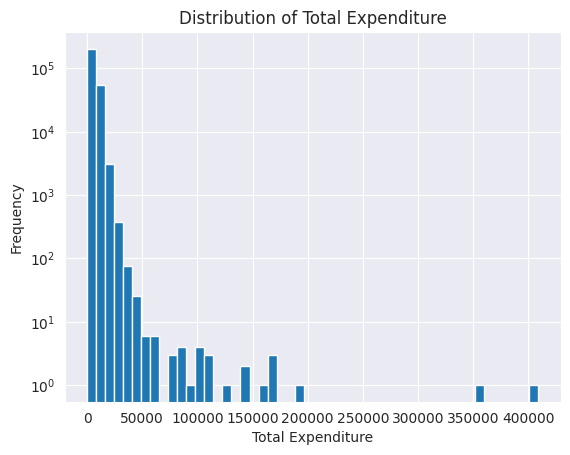

In [35]:
df['total_expenditure'].hist(bins=50)
plt.yscale('log')
plt.title("Total Expenditure Distribution")
plt.xlabel('Total Expenditure')
plt.ylabel('Frequency')
plt.title('Distribution of Total Expenditure')
plt.show()

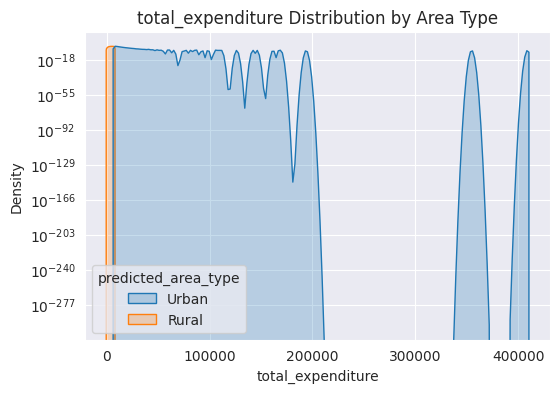

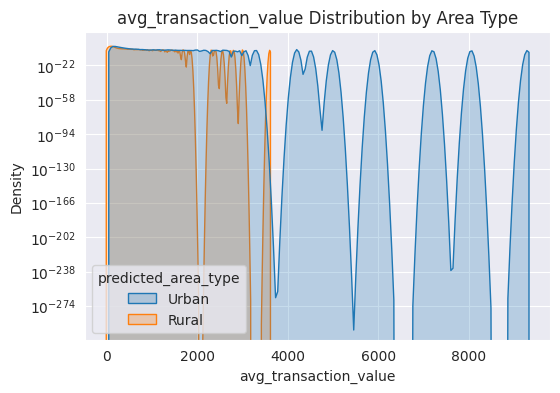

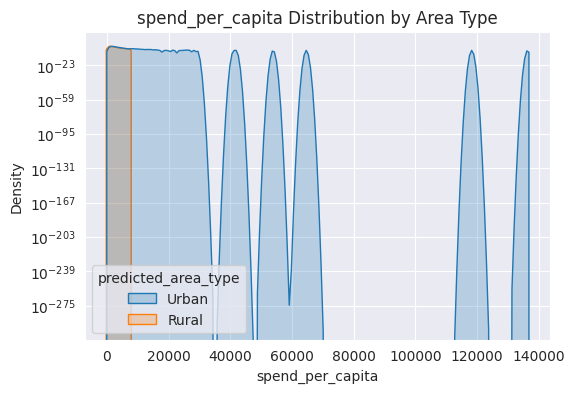

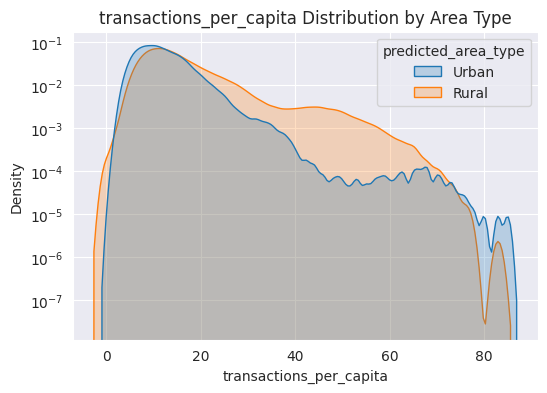

In [36]:
df['spend_per_capita'] = df['total_expenditure'] / df['household_size']
df['transactions_per_capita'] = df['total_transactions'] / df['household_size']
features = [
    'total_expenditure',
    'avg_transaction_value',
    'spend_per_capita',
    'transactions_per_capita',
]

for f in features:
    plt.figure(figsize=(6,4))
    plt.yscale('log')
    plt.title(f"{f} Distribution")
    sns.kdeplot(data=df, x=f, hue='predicted_area_type', fill=True, common_norm=False)
    plt.title(f'{f} Distribution by Area Type')
    plt.show()


Best Accuracy: 0.7398 | spc_thr=2500.0 | tpc_thr=7.0


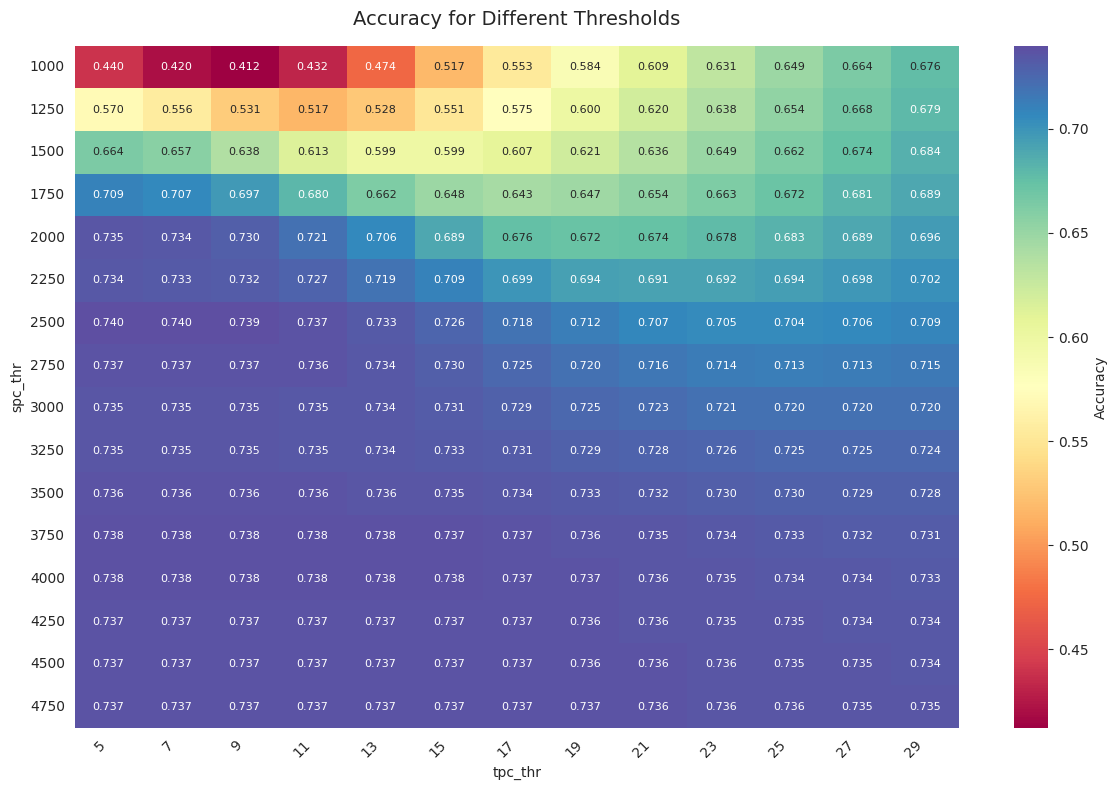

In [37]:

results = []

spc_range = np.arange(1000, 5000, 250)  # spend_per_capita threshold range = total_expenditure/household_size
tpc_range = np.arange(5, 30, 2)         # transactions_per_capita threshold range = total_transactions/household_size

for spc_thr in spc_range:
    for tpc_thr in tpc_range:
        pred = ((df['spend_per_capita'] > spc_thr) &
                (df['transactions_per_capita'] > tpc_thr)).astype(int)
        acc = (pred == (df['predicted_area_type'] == 'Urban')).mean()
        results.append((spc_thr, tpc_thr, acc))

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['spc_thr', 'tpc_thr', 'accuracy'])

# Find best
best_row = results_df.loc[results_df['accuracy'].idxmax()]
print(f"Best Accuracy: {best_row.accuracy:.4f} | spc_thr={best_row.spc_thr} | tpc_thr={best_row.tpc_thr}")

pivot_df = results_df.pivot(index='spc_thr', columns='tpc_thr', values='accuracy')

plt.figure(figsize=(12, 8))  # bigger figure

sns.heatmap(
    data=pivot_df,
    annot=True, fmt=".3f",
    cmap="Spectral",
    annot_kws={"size": 8},   # smaller text
    cbar_kws={'label': 'Accuracy'}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Accuracy for Different Thresholds", fontsize=14, pad=15)
plt.tight_layout()
plt.show()



In [38]:
df.groupby('sector')['total_expenditure'].describe()

,count,mean,std,min,25%,50%,75%,max
sector,,,,,,,,
11,1721.0,6914.972690,4459.864862,768.0,4582.00,6290.0,8536.00,126404.0
12,32795.0,6644.139168,4220.305875,0.0,4292.00,6034.0,8202.00,354774.0
13,6484.0,6390.842227,3604.364279,0.0,4199.75,5832.0,7800.50,109616.0
21,7433.0,6540.758778,3519.339563,0.0,4164.00,5910.0,8244.00,59110.0
22,35896.0,6421.397704,3457.015478,0.0,4130.00,5872.0,8050.00,111542.0
23,134505.0,5895.539385,3406.125677,0.0,3829.00,5388.0,7312.00,408990.0
31,1747.0,7198.239267,3956.394224,0.0,4592.00,6418.0,8846.00,41082.0
32,13040.0,7014.375613,4257.471521,0.0,4502.00,6456.0,8750.00,193910.0
41,587.0,8284.977853,4360.690234,1292.0,5375.00,7386.0,9938.00,40958.0


In [47]:
sector_median = df.groupby('sector')['total_expenditure'].median().to_dict()

# Step 1: Define the features used for clustering
feature_cols = [
    'total_expenditure',
    'avg_transaction_value',
    'total_transactions',
    'unique_items_purchased'
]

# Step 2: Run K-Means prediction
df['cluster'] = kmeans.predict(df[feature_cols])

# Step 3: Map clusters to area types (example mapping)
cluster_to_label = {0: 'Urban', 1: 'Rural'}
df['predicted_area_type'] = df['cluster'].map(cluster_to_label)

# Step 4: Apply vectorized rule-based override
upper_thresh = df['sector'].map(sector_median) * 1.5
lower_thresh = df['sector'].map(sector_median) * 0.75

df['final_area_type'] = df['predicted_area_type']
df.loc[df['total_expenditure'] > upper_thresh, 'final_area_type'] = 'Urban'
df.loc[df['total_expenditure'] < lower_thresh, 'final_area_type'] = 'Rural'

# Step 5: Silhouette Score
from sklearn.metrics import silhouette_score
features = ['total_expenditure', 'avg_transaction_value', 'total_transactions']
sample_df = df.sample(n=10000, random_state=42)  # take 10k rows max
sil_score = silhouette_score(sample_df[feature_cols], sample_df['cluster'])
print(f"Silhouette Score (sampled): {sil_score:.3f}")

# Step 6: How many changes after rule override
changes = (df['predicted_area_type'] != df['final_area_type']).sum()
print(f"Households changed by rule: {changes}")


# predicted_area_type → from pure KMeans
# final_area_type → KMeans + sector median rule


Silhouette Score (sampled): 0.586
Households changed by rule: 122447
